In [1]:
### set up the notebook
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=100) 

plt.rcParams.update({'font.size': 16})

In [2]:
def remove_outliers_IQR(data, limit):
    len_nan = len(data[np.isnan(data)])
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - limit * iqr
    upper_bound = q3 + limit * iqr
    # where data is outside bounds, replace with nan
    data_cp = data.copy()
    data_cp[(data_cp < lower_bound) | (data_cp > upper_bound)] = np.nan
    print('Removed %d / %d points' % (np.sum(np.isnan(data_cp))-len_nan, len(data.flatten())))
    return data_cp

In [3]:
# load the buoy data
buoy_swh = xr.open_dataset('/data/hendreya/bass_strait/data/to_publish/GNSS_at_SWOT_times.nc')
buoy_loc = pd.read_csv('./data/buoy_locations.csv')

# load the SWOT data
swot_swh = xr.open_dataset('/data/hendreya/bass_strait/data/to_publish/SWOT_SWH_at_buoys.nc')


In [4]:
### reindex the buoy data to SWOT times (as some SWH data cycles are missing)

buoy_swh = buoy_swh.reindex(time=swot_swh.time.values, method='nearest', tolerance='1H')

In [5]:
### calculate residuals and remove outliers

resid_5km = swot_swh.swh_5km.values - buoy_swh.swh.values
resid_2km = swot_swh.swh_2km.values - buoy_swh.swh.values

resid_5km_clean = resid_5km.copy()
resid_2km_clean = resid_2km.copy()

for i in range(9):
    resid_5km_clean[i,:] = remove_outliers_IQR(resid_5km[i,:], 1.5)
    resid_2km_clean[i,:] = remove_outliers_IQR(resid_2km[i,:], 1.5)

buoy_swh['buoy_swh_clean'] = buoy_swh.swh.copy()
swot_swh['swh_2km_clean'] = swot_swh.swh_2km.copy()

for i in range(9):
    buoy_swh['buoy_swh_clean'][i,:][np.isnan(resid_2km_clean[i,:])] =  np.nan
    swot_swh['swh_2km'][i,:][np.isnan(resid_2km_clean[i,:])] =  np.nan

Removed 3 / 95 points
Removed 3 / 95 points
Removed 3 / 95 points
Removed 6 / 95 points
Removed 5 / 95 points
Removed 5 / 95 points
Removed 4 / 95 points
Removed 5 / 95 points
Removed 1 / 95 points
Removed 2 / 95 points
Removed 3 / 95 points
Removed 3 / 95 points
Removed 0 / 95 points
Removed 0 / 95 points
Removed 7 / 95 points
Removed 8 / 95 points
Removed 0 / 95 points
Removed 0 / 95 points


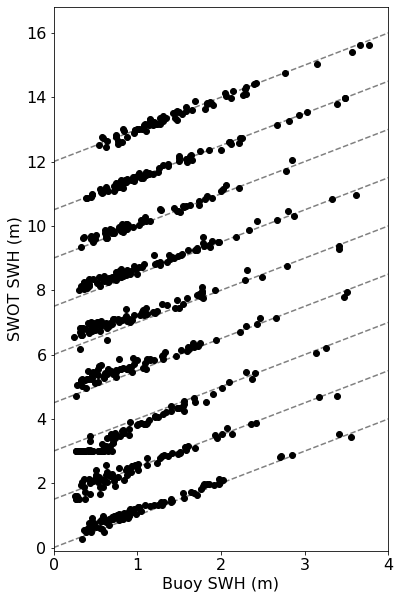

sn40 mean: -0.02 m  std dev: 0.10 m
sn20 mean: -0.00 m  std dev: 0.07 m
sn06 mean: 0.10 m  std dev: 0.09 m
ss05 mean: 0.16 m  std dev: 0.12 m
ss20 mean: 0.25 m  std dev: 0.17 m
ss30 mean: 0.22 m  std dev: 0.17 m
ss40 mean: -0.27 m  std dev: 0.17 m
swxt mean: -0.01 m  std dev: 0.16 m
sext mean: 0.14 m  std dev: 0.11 m


In [10]:
### plot the buoy vs swot

fig, ax = plt.subplots(1, 1, figsize=(6, 10))
for i in range(9):
    offset = 12
    offset = offset-i*1.5
    ax.scatter(buoy_swh['buoy_swh_clean'][i], swot_swh['swh_2km'][i]+offset, marker='o', label=f'buoy {buoy_loc.ID[i]}', c='k', zorder=5)
    ax.plot([0, 4], [offset, offset+4], linestyle='--', c='grey', zorder=1)
ax.set_ylim(-0.1, 16.8)
ax.set_xlim(0, 4)
ax.set_xlabel('Buoy SWH (m)')
ax.set_ylabel('SWOT SWH (m)')
plt.show()


# print statistics for each site
for i in range(9):
    print(str(buoy_loc.ID[i]) + ' mean: %0.2f m  std dev: %0.2f m' % ((np.nanmean(swot_swh['swh_2km'][i] - buoy_swh['buoy_swh_clean'][i])), (np.nanstd(swot_swh['swh_2km'][i] - buoy_swh['buoy_swh_clean'][i]))))


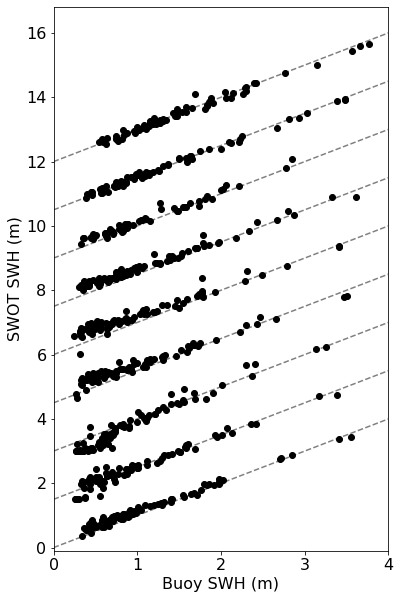

sn40 mean: -0.00 m  std dev: 0.09 m
sn20 mean: 0.01 m  std dev: 0.07 m
sn06 mean: 0.12 m  std dev: 0.10 m
ss05 mean: 0.17 m  std dev: 0.12 m
ss20 mean: 0.24 m  std dev: 0.17 m
ss30 mean: 0.19 m  std dev: 0.15 m
ss40 mean: -0.13 m  std dev: 0.21 m
swxt mean: 0.00 m  std dev: 0.16 m
sext mean: 0.14 m  std dev: 0.10 m


In [11]:
# repeat for SWOT 5 km SWH

fig, ax = plt.subplots(1, 1, figsize=(6, 10))
for i in range(9):
    offset = 12
    offset = offset-i*1.5
    ax.scatter(buoy_swh['buoy_swh_clean'][i], swot_swh['swh_5km'][i]+offset, marker='o', label=f'buoy {buoy_loc.ID[i]}', c='k', zorder=5)
    ax.plot([0, 4], [offset, offset+4], linestyle='--', c='grey', zorder=1)
ax.set_ylim(-0.1, 16.8)
ax.set_xlim(0, 4)
ax.set_xlabel('Buoy SWH (m)')
ax.set_ylabel('SWOT SWH (m)')
plt.show()

# print statistics for each site
for i in range(9):
    print(str(buoy_loc.ID[i]) + ' mean: %0.2f m  std dev: %0.2f m' % ((np.nanmean(swot_swh['swh_5km'][i] - buoy_swh['buoy_swh_clean'][i])), (np.nanstd(swot_swh['swh_5km'][i] - buoy_swh['buoy_swh_clean'][i]))))

In [9]:
### print combined statistics

resid_5km_clean_flat = resid_5km_clean.flatten()
resid_2km_clean_flat = resid_2km_clean.flatten()
buoy_swh_flat = buoy_swh.buoy_swh_clean.values.flatten()

print('Overall 5km stdev: %.2f m  RMSE: %.2f m  mean: %.2f m  n = %d' % (np.nanstd(resid_5km_clean_flat), np.sqrt(np.nanmean(resid_5km_clean_flat**2)), np.nanmean(resid_5km_clean_flat), len(resid_5km_clean_flat[~np.isnan(resid_5km_clean_flat)])))
print('Overall 2km stdev: %.2f m  RMSE: %.2f m  mean: %.2f m  n = %d' % (np.nanstd(resid_2km_clean_flat), np.sqrt(np.nanmean(resid_2km_clean_flat**2)), np.nanmean(resid_2km_clean_flat), len(resid_2km_clean_flat[~np.isnan(resid_2km_clean_flat)])))

resid_5km_clean_flat[buoy_swh_flat<1] = np.nan
resid_2km_clean_flat[buoy_swh_flat<1] = np.nan

print('')
print('high waves')
print('Overall 5km stdev: %.2f m  RMSE: %.2f m  mean: %.2f m  n = %d' % (np.nanstd(resid_5km_clean_flat), np.sqrt(np.nanmean(resid_5km_clean_flat**2)), np.nanmean(resid_5km_clean_flat), len(resid_5km_clean_flat[~np.isnan(resid_5km_clean_flat)])))
print('Overall 2km stdev: %.2f m  RMSE: %.2f m  mean: %.3f m  n = %d' % (np.nanstd(resid_2km_clean_flat), np.sqrt(np.nanmean(resid_2km_clean_flat**2)), np.nanmean(resid_2km_clean_flat), len(resid_2km_clean_flat[~np.isnan(resid_2km_clean_flat)])))

print('')
print()

Overall 5km stdev: 0.17 m  RMSE: 0.19 m  mean: 0.08 m  n = 669
Overall 2km stdev: 0.21 m  RMSE: 0.22 m  mean: 0.06 m  n = 682

high waves
Overall 5km stdev: 0.12 m  RMSE: 0.13 m  mean: 0.05 m  n = 307
Overall 2km stdev: 0.12 m  RMSE: 0.12 m  mean: 0.029 m  n = 311


